# Forecasting strategies

There are 5 possible forecasting strategies:

* Recursive: sequentially forecasts `step` points and use them to forecast next points.
* Direct: forecasts `horizon` points independently using single model.
* DirRec: calculates the forecasts with different models for every horizon and, at each time step, it enlarges the set of inputs by adding forecasts of the previous step. 
* MIMO: learns one multi-output model on `horizon` points.
* DIRMO: sequentially forecasts `step` points with one multi-output model and use them to forecast next points.


The first two of these were implemented in ETNA, and we will take a closer look at them in this notebook.

Notebook navigation:
* [Imports and constants](#0-imports-and-constants)
* [Load dataset](#1-load-dataset)
* [Recursive strategy](#2-recursive-strategy)
    * [AutoRegressivePipeline](#21-autoregressivepipeline)
* [Direct strategy](#3-direct-strategies)
    * [Pipeline](#31-pipeline)
    * [DirectEnsemble](#32-directensemble)
    * [assemble_pipelines + DirectEnsemble](#33-assemble-pipelines-with-ensembles-method-assemblepipelines-class-directensemble)
* [Summary](#4summary)

## 0. Imports and constants

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from etna.datasets import TSDataset
from etna.models import CatBoostModelPerSegment
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAE, MAPE
from etna.analysis import plot_backtest

HORIZON = 14
HISTORY_LEN = 5 * HORIZON

## 1. Load Dataset

Let's load and plot the dataset:

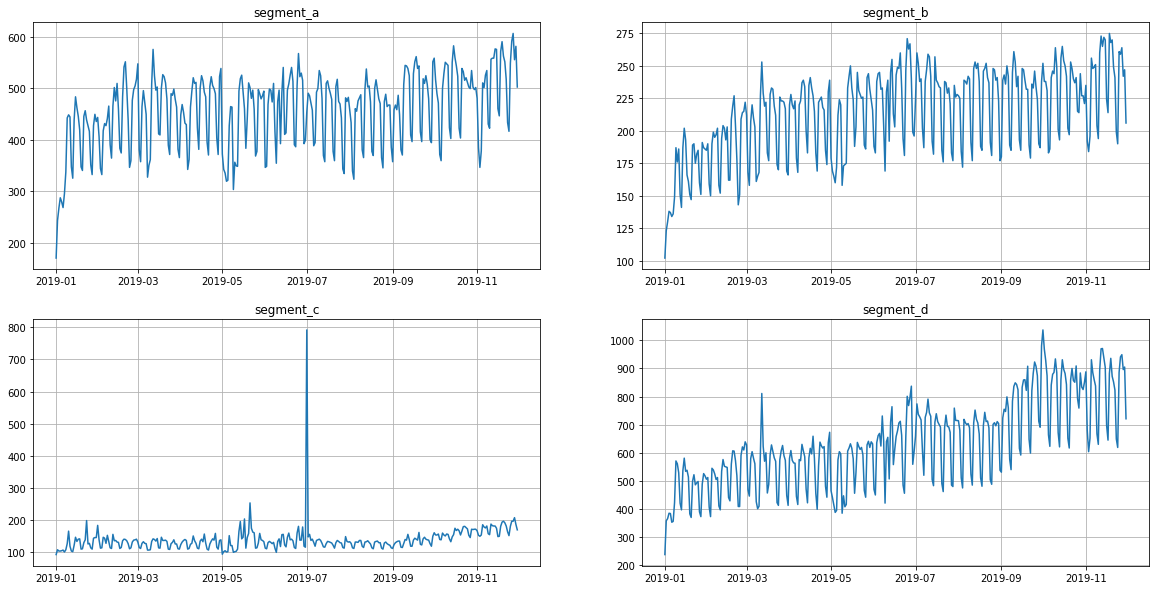

In [3]:
df = pd.read_csv("data/example_dataset.csv")
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.plot()

## 2. Recursive strategy

Recursive strategy in ETNA is implemented via AutoregressivePipeline.

### 2.1 AutoRegressivePipeline

AutoRegressive pipeline is pipeline, which iteratively forecasts `step` values ahead and after that uses forecasted values to build the features for the next steps. 

* Could be slow in case of small `step`, since the method needs to recalculate features $\lceil{\frac{horizon}{step}} \rceil$ times
* Allows to use lags, that are lower than `HORIZON`
* Could be imprecise on forecastings with large horizons. The thing is that we accumulate errors of forecastins for further horizons. 
* Stable for noise-free time series

##### Note:
We will add linear trend into the model(because we are working with tree-based models) and use target's lags as features

In [4]:
from etna.pipeline import AutoRegressivePipeline

In [5]:
model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(1, 21)], out_column="target_lag"),
]

autoregressivepipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON, step=1)
metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)
autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.7s finished


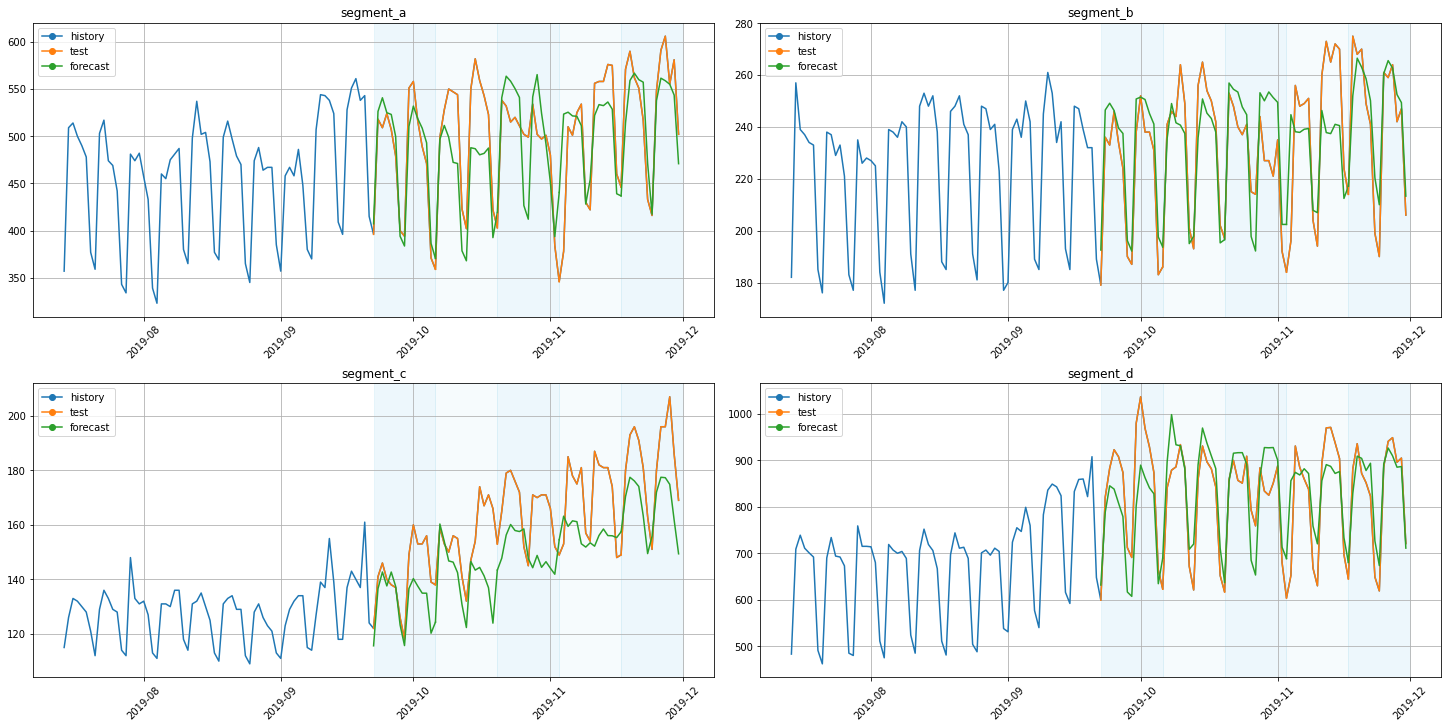

In [6]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

## 3. Direct Strategy

Recursive strategy in ETNA is implemented via Pipeline and DirectEnsemble. This strategy assumes conditional independence of forecasts.

### 3.1 Pipeline

Pipeline implements the version of direct strategy, where the only one model is fitted to forecast all the points in the future. This implies the several things:

* Pipeline doesn't accept lags less than `horizon`
* This is the most time-efficient method: both in traning and in forecasting
* This method might lose the quality with the growth of horizon when using the lags, as the only horizon-far lags are available for all the points

##### Note:

As mentioned above, we cannot use lags less than `horizon`, so now we will use lags from `horizon` to 40

In [7]:
from etna.pipeline import Pipeline

In [8]:
model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=list(range(HORIZON, 34)), out_column="target_lag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])
pipeline_metrics = metrics_pipeline_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.5s finished


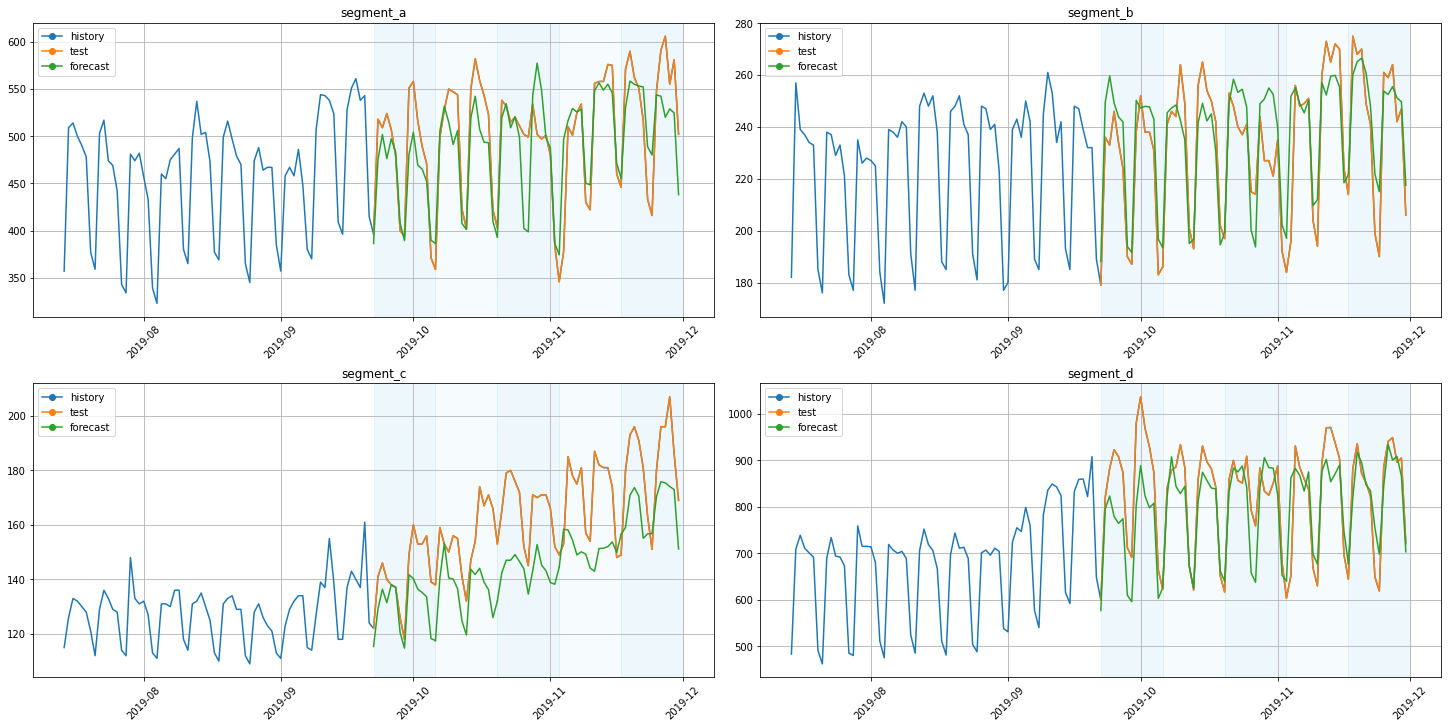

In [9]:
plot_backtest(forecast_pipeline_df, ts, history_len=HISTORY_LEN)

### 3.2 DirectEnsemble 

DirectEnsemble fits the separate pipeline to forecast each time subsegment. Forecasting the future it selects base pipeline with the shortest horizon that covers the timestamp of current forecasted point. Let's see an example of choosing base pipeline for forecastings:

![title](./assets/forecasting_strategies/ensemle.png)



* This method can be useful when we have different pipelines, that are effective on different horizons.
* The computational time growth with the number of base pipelines.
* The forecasts from this strategy might look like a "broken curve", this happens because they are obtained from the independent models

#### Example
Let's build the separate pipeline for each week of interest. The first week will be forecasted using the lags from 7 to 27 and the second one with lags from 14 to 34. We expect that the using of the near lags for the first week might improve the forecast quality

First, let's build our pipelines:

In [10]:
horizons = [7, 14]

model_1 = CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(horizons[0], 27)], out_column="target_lag"),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostModelPerSegment()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(horizons[1], 34)], out_column="target_lag"),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Secondly, we will create ensemble and forecasts:

In [11]:
from etna.ensembles import DirectEnsemble

In [12]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])
ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   1

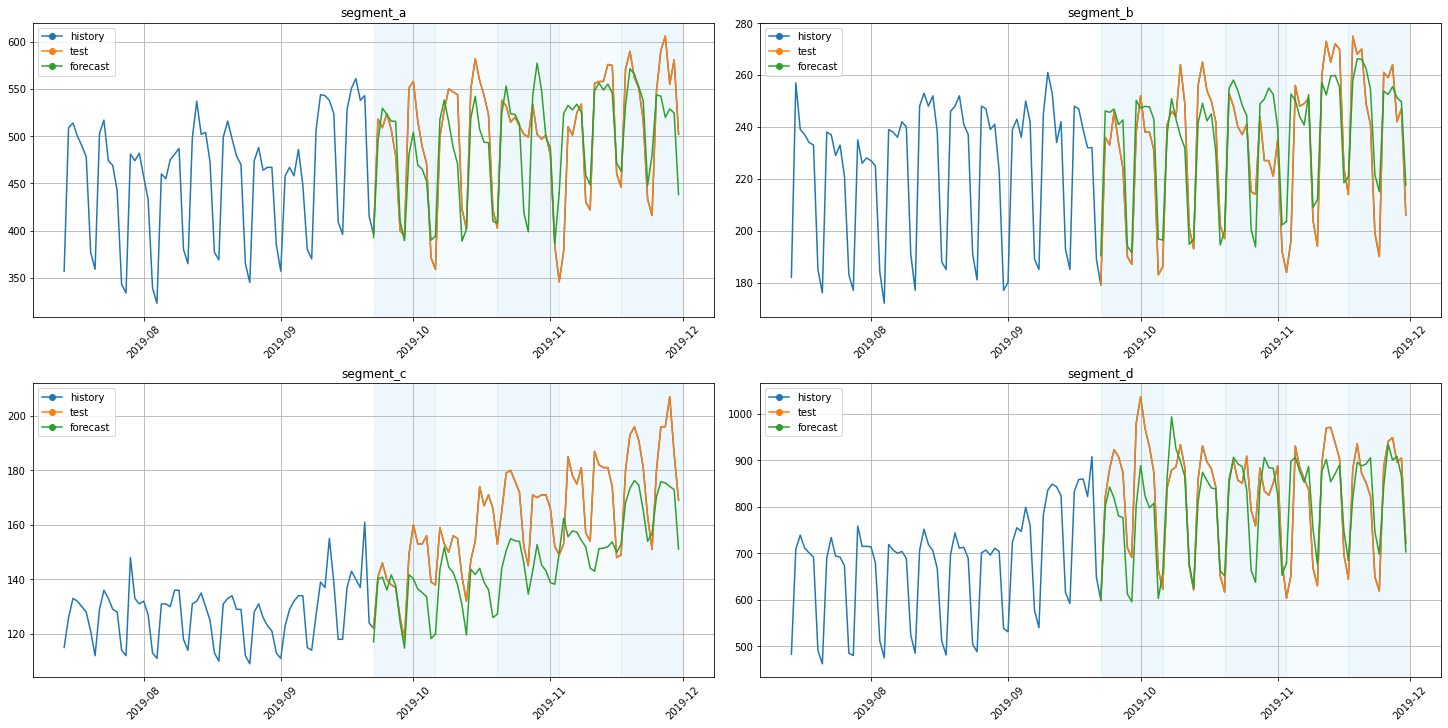

In [13]:
plot_backtest(forecast_ensemble_df, ts, history_len=HISTORY_LEN)

### 3.3 assemble pipelines with DirectEnsemble

DirectEnsemble described above requires the building of the separate pipeline for each of the time subsegment. This pipelines often has many common parts and differs only in the few places. To make the definition of the pipelines a little bit shorter you can use `assemble_pipelines`. It generates the pipelines using the following rules:

1. Input models(horizons) can be specified as one model(horizon) or as a sequence of models(horizons). In first case all generated pipelines will have input model(horizon) and in the second case `i`-th pipeline will hold `i`-th model(horizon). 
2. Transforms can be specified as a sequence of transform or as a sequence of sequence of transforms. Let's look at some examples to understand better transformations with transforms:

Let's consider that `A`, `B`, `C`, `D`, `E` are different transforms.

### Example 1

If input transform sequence is `[A, B, C]`, function will transformate in `[A, B, C]` for each pipeline

### Example 2

If input transform sequence is `[A, [B, C], D, E]`, function will put `[A, B, D, E]` for the first generated pipeline and `[A, C, D, E]` for the second.

### Example 3

If input transform sequence is `[A, [B, C], [D, E]]`, function will put `[A, B, D]` for the first generated pipeline and `[A, C, E]` for the second.

### Example 4

If input transform sequence is `[A, [B, None]]`, function will put `[A, B]` for the first generated pipeline and `[A]` for the second.


Let's build the ensemble from the previous section using `assemble_pipelines`

In [14]:
from etna.pipeline import assemble_pipelines

In [15]:
models = [CatBoostModelPerSegment(), CatBoostModelPerSegment()]
transforms = [
    LinearTrendTransform(in_column="target"),
    [
        LagTransform(in_column="target", lags=[i for i in range(horizons[0], 27)], out_column="target_lag"),
        LagTransform(in_column="target", lags=[i for i in range(horizons[1], 34)], out_column="target_lag"),
    ],
]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], out_column = 'target_lag', )], horizon = 7, ),
 Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], out_column = 'target_lag', )], horizon = 14, )]

Pipelines generation process looks now a bit simpler, is't it? Now it's time to create DirectEnsemble out of them:

In [16]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2, forecast_ensemble_df_2, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   1

Let's check that the forecasts has not changed:

In [17]:
pd.testing.assert_frame_equal(metrics_ensemble_df_2, metrics_ensemble_df)

## 4.Summary

In this notebook we discussed forecasting strategies available in ETNA and look at the examples of their usage. In conclusion, let's compare their quality on the considered dataset:

In [18]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metrics, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)
df_res

,SMAPE,MAE,MAPE
direct_ensemble,7.157533,28.853936,7.004223
pipeline,7.257143,28.350630,7.036824
autoregressive_pipeline,7.037945,28.911537,6.922453
